# Perturb prediction

The following tutorial demonstrate how to use scButterfly framework making translation between the gene expressions of control and stimulated groups.

We focus on the scRNA-seq perturbation and adapt a pair of encoder and decoder seperately for control and stimulate groups. Because the perturb data is unpaired data, we follow the strategy in [unpaired data training](../RNA_ATAC_unpaired_prediction/RNA_ATAC_unpaired_scButterfly-T.ipynb).

There are three part of this tutorial:

* **Load data and data pre-processing**. This part will tell you how to load perturbation responses data to scButterfly model. 

* **Construct and train a scButterfly model**. This part will tell you how to generate and train a scButterfly model correctly.

* **Get prediction and evaluate the performance**. This part will tell you how to get prediction from scButterfly model and evaluate the performance of prediction.

In [1]:
import scanpy as sc
import pandas as pd

## Load data and data pre-processing

Here we use the human peripheral blood mononuclear cells (PBMC) stimulated with interferon (IFN-β) as example. ([Lotfollahi, M, et al., 2019](https://www.nature.com/articles/s41592-019-0494-8))

In [2]:
sc_data = sc.read_h5ad('PT_PBMC.h5ad')

/home/atac2rna/anaconda3/envs/bt/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
sc_data

AnnData object with n_obs × n_vars = 18868 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

/home/atac2rna/anaconda3/envs/bt/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/atac2rna/anaconda3/envs/bt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/atac2rna/anaconda3/envs/bt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


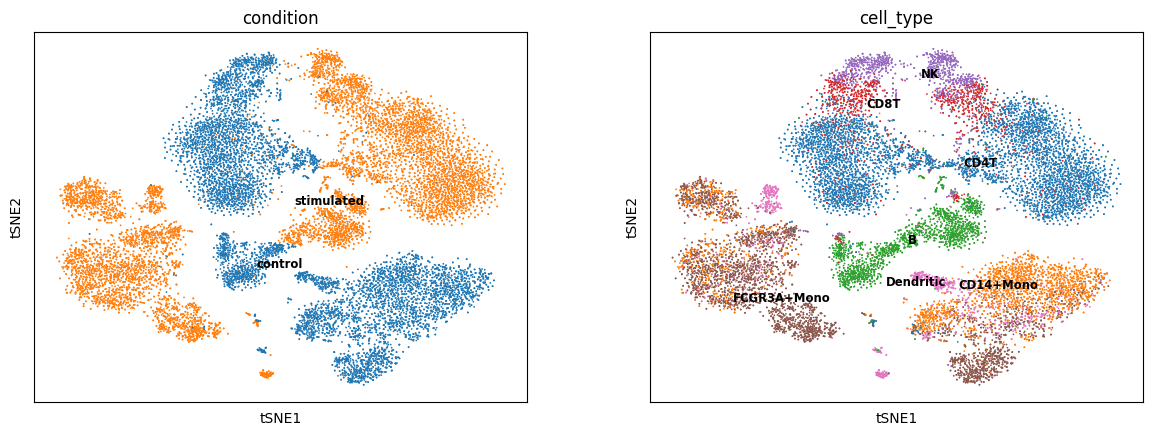

In [4]:
sc.pp.pca(sc_data)
sc.pp.neighbors(sc_data)
sc.tl.tsne(sc_data)
sc.pl.tsne(sc_data, color=['condition', 'cell_type'], legend_loc='on data', legend_fontsize='small')

In [5]:
Control_data = sc_data[sc_data.obs.condition == 'control']
Stimulate_data = sc_data[sc_data.obs.condition == 'stimulated']
Control_data.obs.index = [str(i) for i in range(Control_data.X.shape[0])]
Stimulate_data.obs.index = [str(i) for i in range(Stimulate_data.X.shape[0])]

<div class="alert note">
<p>

**Note**

We use the processed data provided in scGen([Lotfollahi, M, et al., 2019](https://www.nature.com/articles/s41592-019-0494-8)), to keep consistency for evaluation, we choose no preprocessing here. You could feel free for using other proper processing.

</p>
</div>

In [6]:
from scButterfly.split_datasets import *
id_list = unpaired_split_dataset_perturb(Control_data, Stimulate_data)
train_id_r, train_id_a, validation_id_r, validation_id_a, test_id_r, test_id_a = id_list[0]

In [7]:
Control_data[test_id_r].obs.cell_type

index
AAACATACATTTCC-1-control    Dendritic
AAACATACCTGGTA-1-control    Dendritic
AAACGGCTCTTCGC-1-control    Dendritic
AAACGGCTTCTCTA-1-control    Dendritic
AAAGTTTGTGTGGT-1-control    Dendritic
                              ...    
TATACAGAGACGTT-1-control    Dendritic
ACCCGTTGGCTGAT-1-control    Dendritic
ATCACGGAACCCTC-1-control    Dendritic
AACTCTTGGTAGGG-1-control    Dendritic
AATTGATGCCACCT-1-control    Dendritic
Name: cell_type, Length: 670, dtype: category
Categories (1, object): ['Dendritic']

## Construct and train a scButterfly model

We could load scButterfly model for perturb from ``scButterfly.train_model_perturb``

<div class="alert warning">
<p>

**Warning**

We propose you to ensure that the settings of parameters for construct model and train model are same with here, while feel free to decide path for logging and model output.

</p>
</div>

In [8]:
from scButterfly.train_model_perturb import Model
import torch
import torch.nn as nn

In [9]:
RNA_input_dim = Control_data.X.shape[1]
ATAC_input_dim = Stimulate_data.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / ATAC_input_dim * 20
kl_div = R_kl_div + A_kl_div

In [10]:
model = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 128, 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 128, ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.5,
    chrom_list = [],
    logging_path = None,
    RNA_data = Control_data,
    ATAC_data = Stimulate_data
)

Train a scButterfly model.

In [11]:
model.train(
    R_encoder_lr = 0.001,
    A_encoder_lr = 0.001,
    R_decoder_lr = 0.001,
    A_decoder_lr = 0.001,
    R_translator_lr = 0.001,
    A_translator_lr = 0.001,
    translator_lr = 0.001,
    discriminator_lr = 0.005,
    R2R_pretrain_epoch = 100,
    A2A_pretrain_epoch = 100,
    lock_encoder_and_decoder = False,
    translator_epoch = 200,
    patience = 50,
    batch_size = 64,
    r_loss = nn.MSELoss(size_average=True),
    a_loss = nn.MSELoss(size_average=True),
    d_loss = nn.BCELoss(size_average=True),
    loss_weight = [1, 1, 1, R_kl_div, A_kl_div, kl_div],
    train_id_r = train_id_r,
    train_id_a = train_id_a,
    validation_id_r = validation_id_r, 
    validation_id_a = validation_id_a, 
    output_path = None,
    seed = 19193,
    kl_mean = True,
    R_pretrain_kl_warmup = 50,
    A_pretrain_kl_warmup = 50,
    translation_kl_warmup = 50,
    load_model = None,
    logging_path = None
)

[INFO] Trainer: Control pretraining ...
Control pretrain: 100%|█████████████████| 100/100 [01:53<00:00,  1.13s/it, train=0.0267, val=0.0290]
[INFO] Trainer: Stimulate pretraining ...
Stimulate pretrain: 100%|███████████████| 100/100 [01:49<00:00,  1.09s/it, train=0.0259, val=0.0272]
[INFO] Trainer: Combine training ...
Combine training: 100%|█████████████████| 200/200 [06:01<00:00,  1.81s/it, train=0.0967, val=0.1003]


## Get prediction and evaluate the performance

You could get using ``model.test`` using ``return_predict=True``. We also provided more information metrics in this function, see in [API](../../API/index.html).

Here we evaluate the prediction performance of model facing unseen types of cell. We mainly focus on two metrics: the number of common DEGs of the top 100 real DEGs versus the top 100 predicted DEGs, and the squared Pearson correlation (R2) for mean gene expression of the top 100 real DEGs between predicted and real stimulated data. We also virsualize the PCA plot, dotplot and regression plot.

[INFO] Tester: get predicting ...
ATAC to RNA predicting...: 100%|██████████████████████████████████████| 6/6 [00:00<00:00, 16.71it/s]
[INFO] Tester: calculate neighbors graph for following test ...


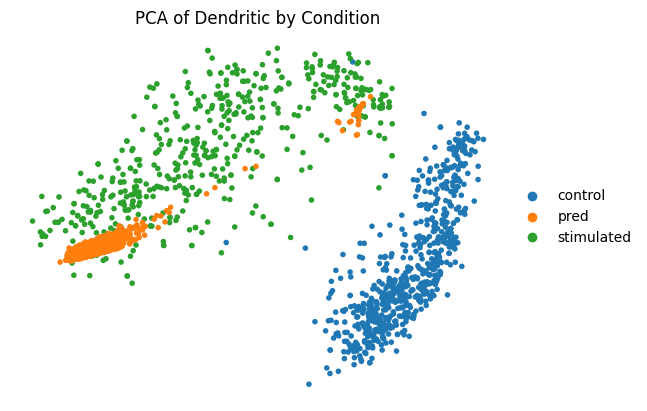

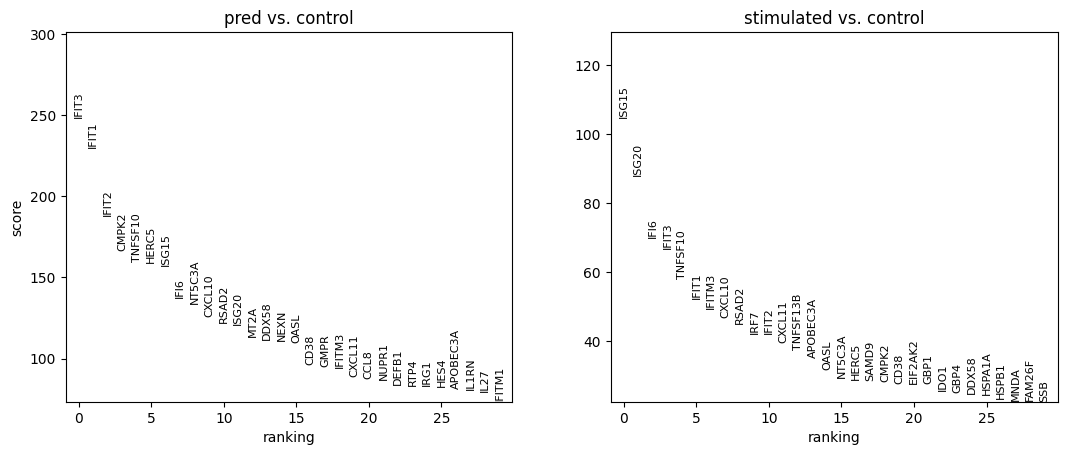

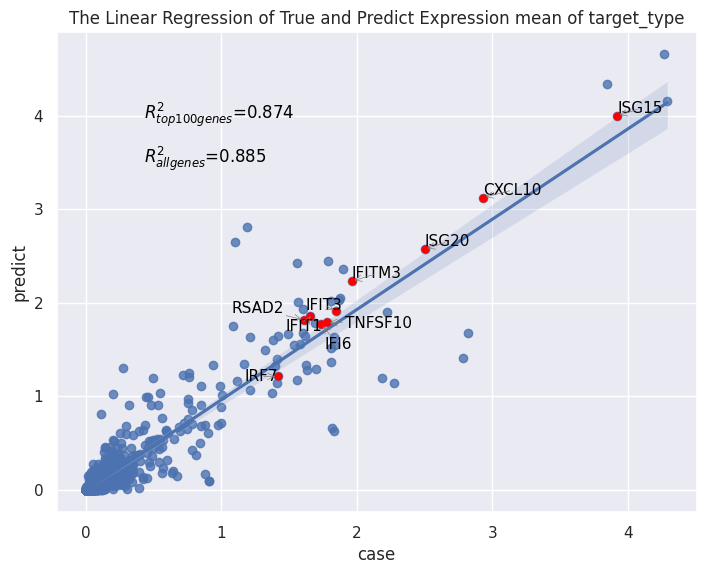

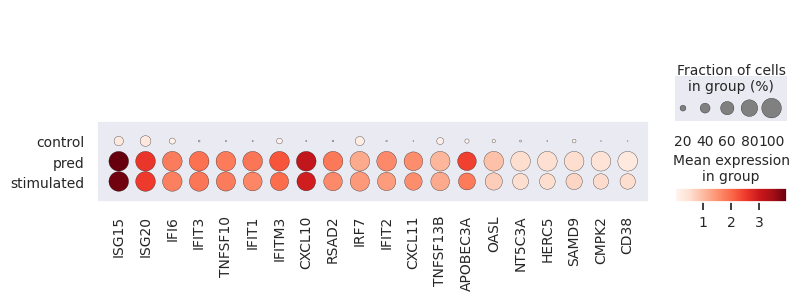

In [12]:
model.test(
    test_id_r = test_id_r,
    test_id_a = test_id_a, 
    model_path = None,
    load_model = False,
    output_path = None,
    test_pca = True,
    test_DEGs = True,
    test_R2 = True,
    test_dotplot = True,
    output_data = False,
    return_predict = False
)

Performance measures are automatically output to ``cluster_index.csv``.

In [13]:
cluster_index = pd.read_csv('cluster_index.csv', index_col=0)
cluster_index

,DEGs,r2mean,r2mean_top100,data_name
con2sti,74,0.885,0.874,Dendritic
